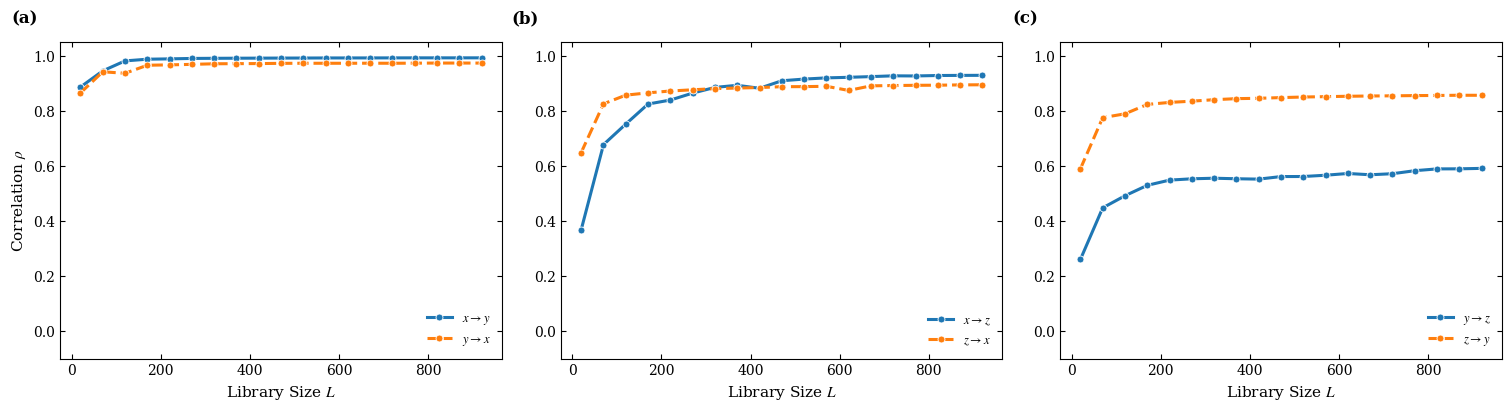

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

dt = 0.01
num_steps = int(1e4)

y = np.zeros((num_steps + 1, 3))
y[0] = np.array([1.0, 1.0, 0.0])

def rossler(xyz, a=0.2, b=0.2, c=5.7):
    x, y, z = xyz
    return np.array([-y - z, x + a * y, b + z * (x - c)])

for i in range(num_steps):
    y[i + 1] = y[i] + rossler(y[i]) * dt

noise_level = 0.05
np.random.seed(42)
y += np.random.normal(0.0, y.std(axis=0) * noise_level, y.shape)

ds = 10
x_ds = y[:, 0][::ds]
y_ds = y[:, 1][::ds]
z_ds = y[:, 2][::ds]
N = len(x_ds)

df = pd.DataFrame({"Time": np.arange(N), "x": x_ds, "y": y_ds, "z": z_ds})

E = 6
tau = 8
exR = 12

sizes_start, sizes_stop, sizes_step = 20, max(21, N - 50), 50
libSizes = f"{sizes_start} {sizes_stop} {sizes_step}"

import pyEDM as edm

out_xy = edm.CCM(dataFrame=df, E=E, tau=tau, columns="x", target="y", libSizes=libSizes, sample=50, exclusionRadius=exR)
out_xz = edm.CCM(dataFrame=df, E=E, tau=tau, columns="x", target="z", libSizes=libSizes, sample=50, exclusionRadius=exR)
out_yz = edm.CCM(dataFrame=df, E=E, tau=tau, columns="y", target="z", libSizes=libSizes, sample=50, exclusionRadius=exR)

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
plt.rcParams['mathtext.fontset'] = 'stix'

FONT_SIZE = 10
plt.rcParams.update({
    'font.size': FONT_SIZE,
    'axes.labelsize': FONT_SIZE + 1,
    'axes.titlesize': FONT_SIZE + 1,
    'xtick.labelsize': FONT_SIZE,
    'ytick.labelsize': FONT_SIZE,
    'legend.fontsize': FONT_SIZE - 1,
    'figure.titlesize': FONT_SIZE + 2,
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    'xtick.top': True,
    'ytick.right': True,
    'lines.linewidth': 2.2,
    'lines.markersize': 5,
    'legend.frameon': False,
    'axes.grid': False,
})

c1_color = '#1f77b4'
c2_color = '#ff7f0e'

def plot_ccm_panel(ax, out_df, pair_name, panel_label):
    L_col = out_df.columns[0]
    var1 = out_df.columns[1]
    var2 = out_df.columns[2]

    label1 = f"${var1.split(':')[0]} \\to {var1.split(':')[1]}$"
    label2 = f"${var2.split(':')[0]} \\to {var2.split(':')[1]}$"

    ax.plot(out_df[L_col], out_df[var1], color=c1_color, marker='o',
            markeredgewidth=0.6, markeredgecolor='white', label=label1)

    ax.plot(out_df[L_col], out_df[var2], color=c2_color, marker='o', linestyle='--',
            markeredgewidth=0.6, markeredgecolor='white', label=label2)

    ax.set_ylim(-0.1, 1.05)
    ax.set_xlabel(r'Library Size $L$')
    if panel_label == '(a)':
        ax.set_ylabel(r'Correlation $\rho$')

    ax.text(-0.05, 1.05, panel_label, transform=ax.transAxes,
            fontsize=12, fontweight='bold', va='bottom', ha='right')

    ax.legend(loc='lower right')

fig, axes = plt.subplots(1, 3, figsize=(15, 4), constrained_layout=True)

plot_ccm_panel(axes[0], out_xy, "$(x, y)$", "(a)")
plot_ccm_panel(axes[1], out_xz, "$(x, z)$", "(b)")
plot_ccm_panel(axes[2], out_yz, "$(y, z)$", "(c)")

plt.savefig("Fig1_CCM_Convergence.pdf", dpi=300)
plt.show()


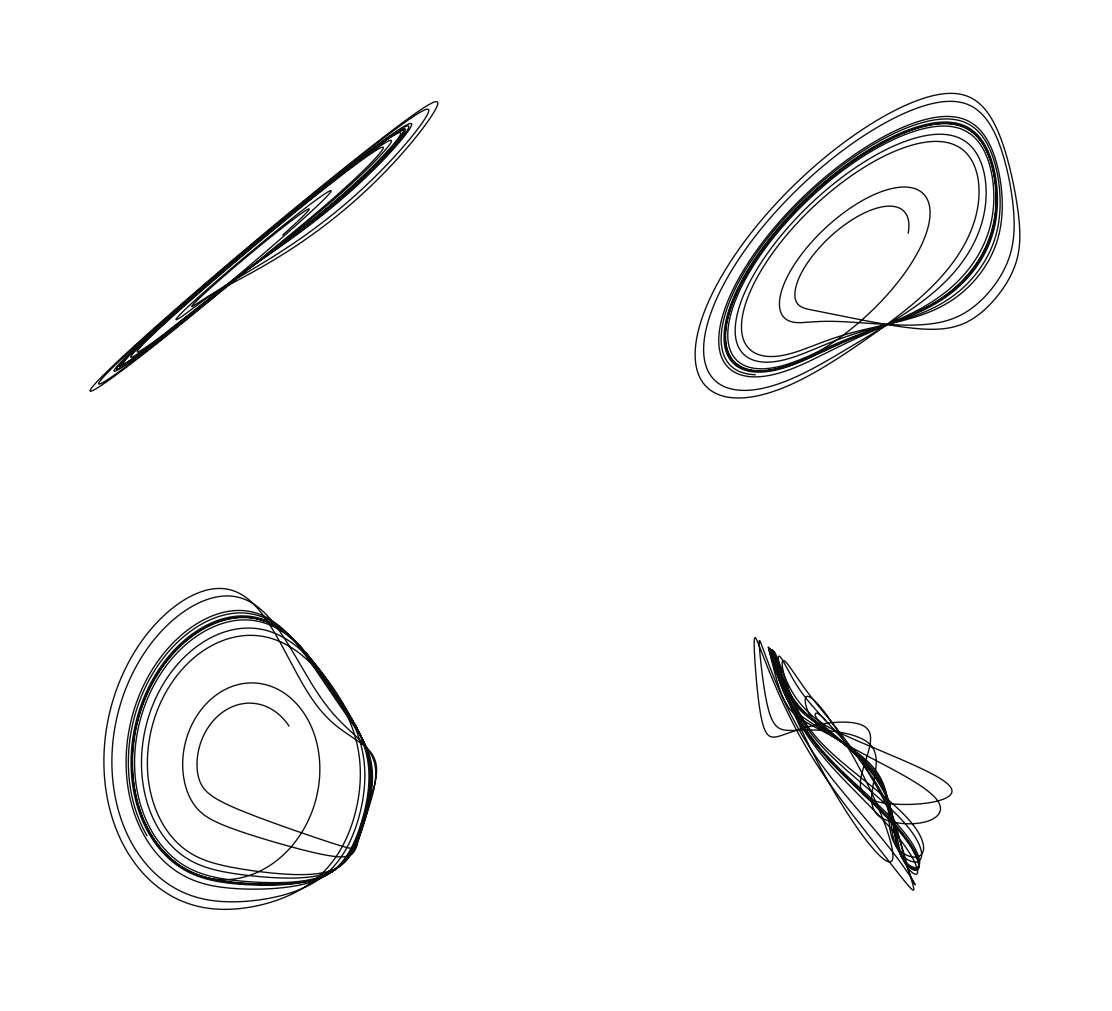

In [ ]:
from mpl_toolkits.mplot3d import Axes3D  

for i in range(num_steps):
    y[i + 1] = y[i] + rossler(y[i]) * dt

noise_level = 0
np.random.seed(42)
y += np.random.normal(0.0, y.std(axis=0) * noise_level, y.shape)

traj = y 
x_full = traj[:, 0]

burn = 2000
x_use = x_full[burn:]

def delay_embed_3d(x_1d, tau_, n_points=6000):
    M = len(x_1d) - 2 * tau_
    if M <= 0:
        raise ValueError(f"tau={tau_} is too large for series length {len(x_1d)}.")
    X = np.column_stack([
        x_1d[:M],
        x_1d[tau_:tau_ + M],
        x_1d[2 * tau_:2 * tau_ + M],
    ])
    if n_points is not None and n_points < len(X):
        idx = np.linspace(0, len(X) - 1, n_points).astype(int)
        X = X[idx]
    return X

taus_to_plot = [5, 50, 100, 200]

fig_emb = plt.figure(figsize=(12, 10), constrained_layout=True)
for k, tau_ in enumerate(taus_to_plot, start=1):
    ax = fig_emb.add_subplot(2, 2, k, projection='3d')
    Xemb = delay_embed_3d(x_use, tau_=tau_, n_points=10000)

    ax.plot(Xemb[:, 0], Xemb[:, 1], Xemb[:, 2], color='k', linewidth=1, alpha=0.95)

    ax.set_xticks([]); ax.set_yticks([]); ax.set_zticks([])
    ax.grid(False)
    ax.set_axis_off()
    ax.set_box_aspect((1, 1, 1))

plt.savefig("Fig2_Rossler_DelayEmbedding_tauSweep.pdf", dpi=300, bbox_inches="tight")
plt.show()

In [ ]:
tau_ccm = 8
E_list = [3, 4, 5, 6]

fig_ccmE, axes = plt.subplots(2, 2, figsize=(12, 10), 
                              sharex=True, sharey=True, 
                              constrained_layout=True)

axes_flat = axes.flatten()

for i, (ax, E_) in enumerate(zip(axes_flat, E_list)):
    out_yz_E = edm.CCM(
        dataFrame=df,
        E=E_,
        tau=tau_ccm,
        columns="y",
        target="z",
        libSizes=libSizes,
        sample=50,
        exclusionRadius=exR
    )

    L_col = out_yz_E.columns[0]
    v1 = out_yz_E.columns[1]  
    v2 = out_yz_E.columns[2] 

    label1 = f"${v1.split(':')[0]} \\to {v1.split(':')[1]}$"
    label2 = f"${v2.split(':')[0]} \\to {v2.split(':')[1]}$"

    ax.plot(out_yz_E[L_col], out_yz_E[v1], color=c1_color, marker='o',
            markeredgewidth=0.6, markeredgecolor='white', label=label1)
    ax.plot(out_yz_E[L_col], out_yz_E[v2], color=c2_color, marker='o', linestyle='--',
            markeredgewidth=0.6, markeredgecolor='white', label=label2)

    #ax.set_title(rf"$E={E_}$, $\tau={tau_ccm}$ (with ds)")
    ax.set_ylim(-0.1, 1.05)

    if i >= 2: 
        ax.set_xlabel(r"Library Size $L$")
    
    if i % 2 == 0: 
        ax.set_ylabel(r"Correlation $\rho$")

    if i == 0:
        ax.legend(loc='lower right')

plt.savefig("Fig3_CCM_yz_tau8_Esweep_vertical.pdf", dpi=300, bbox_inches="tight")
plt.show()